# **Avance 2. Series de tiempo univariadas:**
## **Universidad Nacional de Colombia.**
## **Docente:**

  - [Sergio Alejandro Calderón Villanueva](sacalderonv@unal.edu.co)

## **Autores:**

  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Sharon Juliana Zambrano Ortiz](shzambranoo@unal.edu.co)
  - [Nicolás Alejandro Quenguan Parra](naquenguanp@unal.edu.co)
  - [Aryin Jair Torres Quiñone](artorresq@unal.edu.co)

---
**Nota 1:** Los avances estaban siendo realizados en archivos de Rmarkdown `.Rmd`. Sin embargo, como la intención de este avance es incluir algunos modelos de aprendizaje profundo (Redes neuronales multicapa y redes recurrentes) con el fin de no utilizar recursos de computo de los equipos de cada uno de los autores se entregará el avance 2 como un archivo de jupyter notebook `.ipynb` que además de permitir el uso de computación en la nube para tareas pesadas usando Google Collab cuando los recursos de forma local sean reducidos también (Por ser `python`) permite construir chunks que usen código de `R` y `python` cuyos objetos tienen la posibilidad de interactuar entre sí (Veáse: [R and Python in one Jupyter notebook](https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook))

**Nota 2:** Si se está editando este documento desde Google Collab, no es posible hacer `commit` directamente al repositorio. En cambio, hay que dar en la opción `File > Save a copy in GitHub`.

---

El siguiente código habilita el uso de código de `R` y `python` en simultáneo (Es neceasario el paquete `rpy2`):

In [1]:
%load_ext rpy2.ipython

Ahora se cargan los datos usando `R` y se exporta el objeto a `python`:

In [2]:
%%R -o leche
leche = read.csv("https://raw.githubusercontent.com/Mendivenson/Series-de-tiempo/main/Datos/Volumen%20de%20Acopio%20Total%20%20(2008%20-%202023).csv")
leche = leche[, c('Periodo', 'NACIONAL')]

Cualquier chunk de código que inicie con `%%R` será código `R` por lo que el siguiente código es 100% `python`:

In [3]:
leche

,Periodo,NACIONAL
1,Jan-08,2.458355e+08
2,Feb-08,2.130557e+08
3,Mar-08,2.175541e+08
4,Apr-08,2.224843e+08
5,May-08,2.386657e+08
...,...,...
188,Aug-23,2.979559e+08
189,Sep-23,2.845475e+08
190,Oct-23,2.876751e+08
191,Nov-23,2.809905e+08


En este avance se podrán encontrar tres cosas importantes para cada una de las series:

- Implementaciones de un filtro exponencial (`R`)
- Implementaciones de árboles de decisión binarios (`python`)
- Entrenamiento de redes neuronales multicapa (`python`)
- Entrenamiento de redes neuronales concurrentes (`python`)

---

# Filtro exponencial

---

:00 Esperando :v

## ¿por qué no funciona? xd

---

# Árboles de decisión

---

Los árboles de decisión se generan usando los rezagos de distinto orden de la serie como información adicional utilizada para predecir el valor que la serie tendrá en el tiempo $t + n$ siendo n un número de pasos escogido previamente. Es un método de sencilla implementación, sin embargo, no es muy potente cuando se tienen series con tendencia.

**Nota:** Es prudente revisar si la varianza es estable. Sin embargo, al hacer la transformación de boxcox en la serie de leche mensual no se observan cambios importantes en la estructura de la serie por lo que se decide usar en cambio la serie original.

## **Acopio nacional de leche (mensual)**

Como se observo en el [Avance 1](https://rpubs.com/Mendivenson/Avance1_STdU) la serie del volumen de acopio nacional es una serie con tendencia positiva por lo que será necesario eliminarla esta tendencia para poder continuar con la construcción del árbol. Más adelante, se mostrará la diferencia del método de árboles de decisión para la serie sin tendencia y para la serie con tendencia.

### **Eliminación de la tendencia**

De nuevo, similarmente a lo revisado en [Avance 1](https://rpubs.com/Mendivenson/Avance1_STdU), se escoge el método de suavizamiento kernel para eliminar la tendencia de la serie:

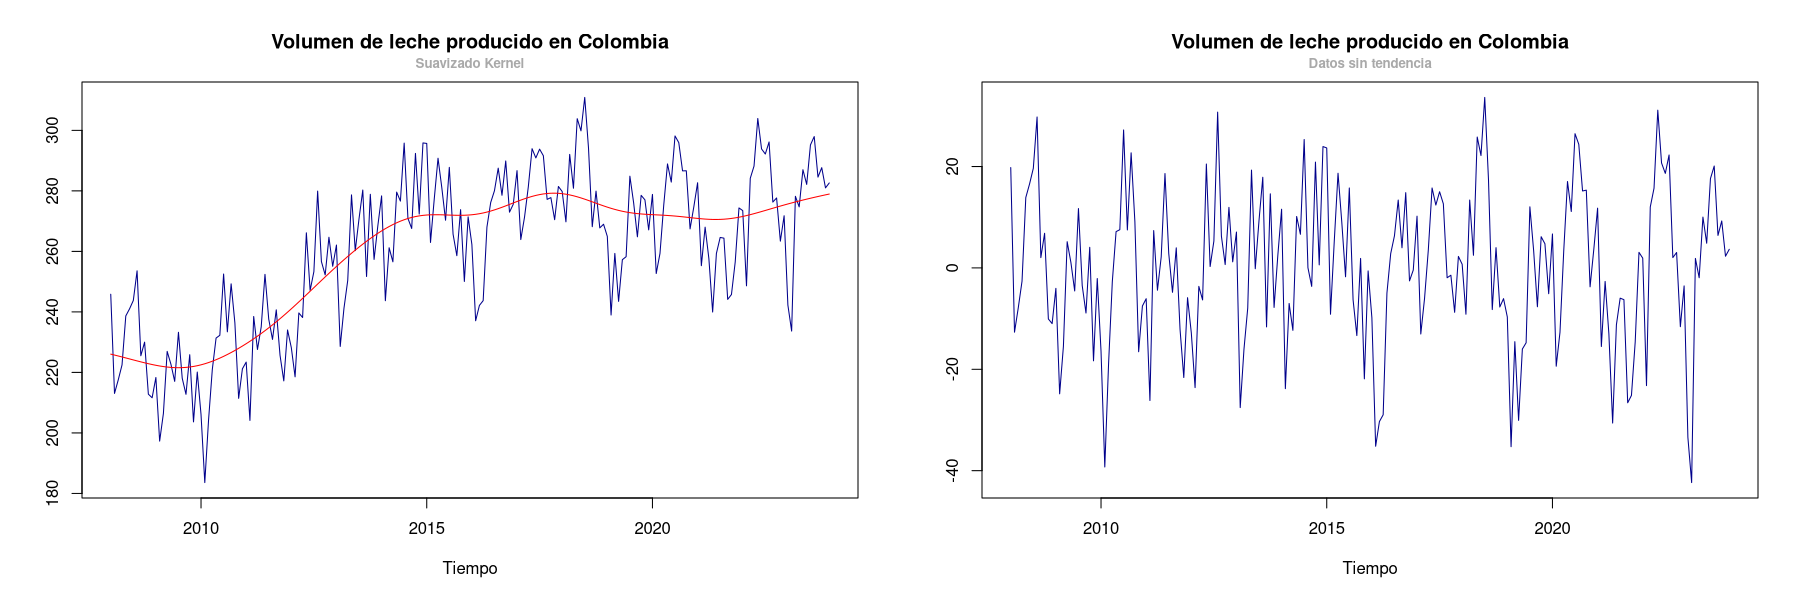

In [4]:
%%R -o leche -w 18 -h 6 --units in -r 100
leche$NACIONAL = leche$NACIONAL/1000000 # Los datos a partir de ahora estarán en millones de litros
lecheTend = leche

tiempo = seq(2008, 2023.95, by = 1/12)
predicciones = ksmooth(y = leche$NACIONAL, x = tiempo, kernel = 'normal', bandwidth = 2.5)$y

# Gráfico
par(mfrow = c(1,2))

# Original y suavizamiento kernel
plot(x = tiempo ,y = leche$NACIONAL, xlab = 'Tiempo', ylab = '', main = 'Volumen de leche producido en Colombia',col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('Suavizado Kernel')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')
lines(x = tiempo,y = predicciones, col = 'red')

# Datos sin tendencia
plot(x = tiempo,y = leche$NACIONAL - predicciones,xlab = 'Tiempo', ylab = '', main = 'Volumen de leche producido en Colombia',col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('Datos sin tendencia')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

# Actualizando el dataframe para devolverlo a python: 
leche$NACIONAL = leche$NACIONAL - predicciones

In [5]:
%%R -o lecheTend
''

[1] ""


### **Selección de rezagos**

Una vez realizada la eliminación de la tendencia, es preciso escoger los rezagos que parecen estar más relacionados con el valor actual de la serie de los demás para incluirlos como covariables en nuestro árbol. Para hacer esto, podemos ayudarnos de un periodograma y algunos gráficos descriptivos también ya realizados en el [Avance 1](https://rpubs.com/Mendivenson/Avance1_STdU):

#### Autocorrelación y autocorrelación parcial:

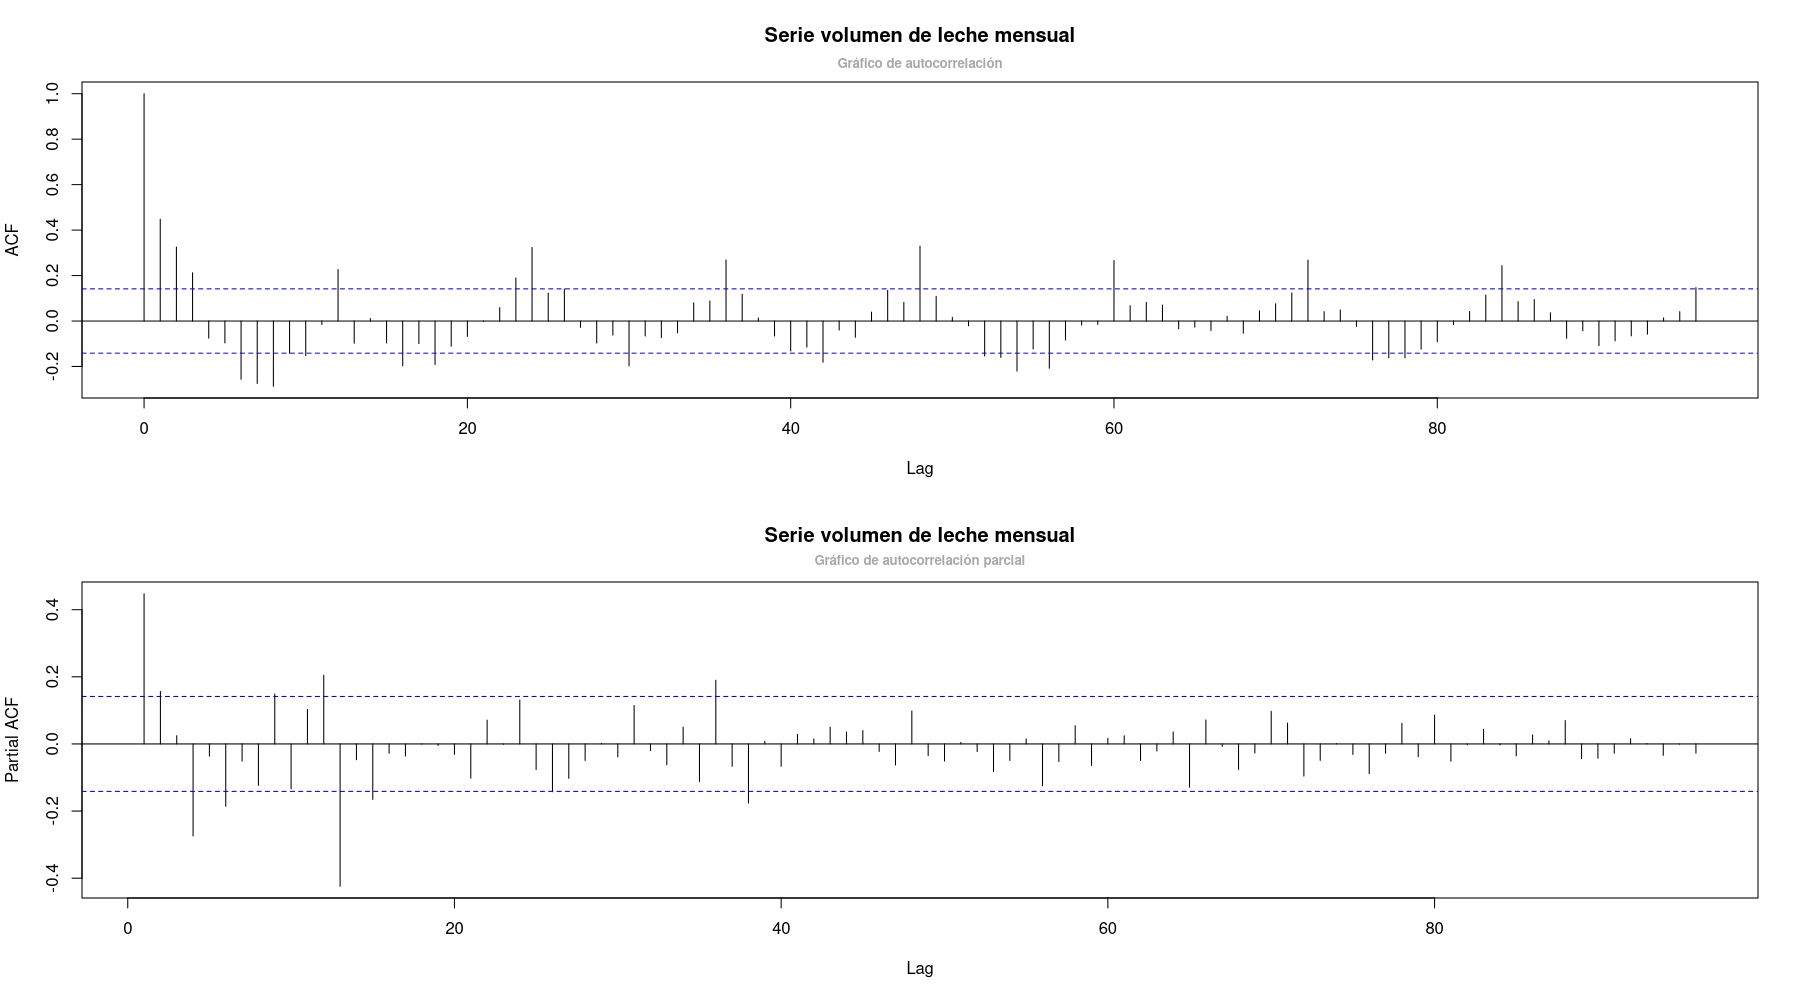

In [6]:
%%R -w 18 -h 10 --units in -r 100
par(mfrow = c(2,1))

# Autocorrelación
acf(leche$NACIONAL, lag.max = 96, main = 'Serie volumen de leche mensual')
mtext(bquote(bold('Gráfico de autocorrelación')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

# Autocorrelación parcial
pacf(leche$NACIONAL, lag.max = 96, main = 'Serie volumen de leche mensual')
mtext(bquote(bold('Gráfico de autocorrelación parcial')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

La autocorrelación y autocorrelación parcial sugieren patrones anuales. Revisemos la serie más a fondo.

#### Boxplot mensual y subseries:

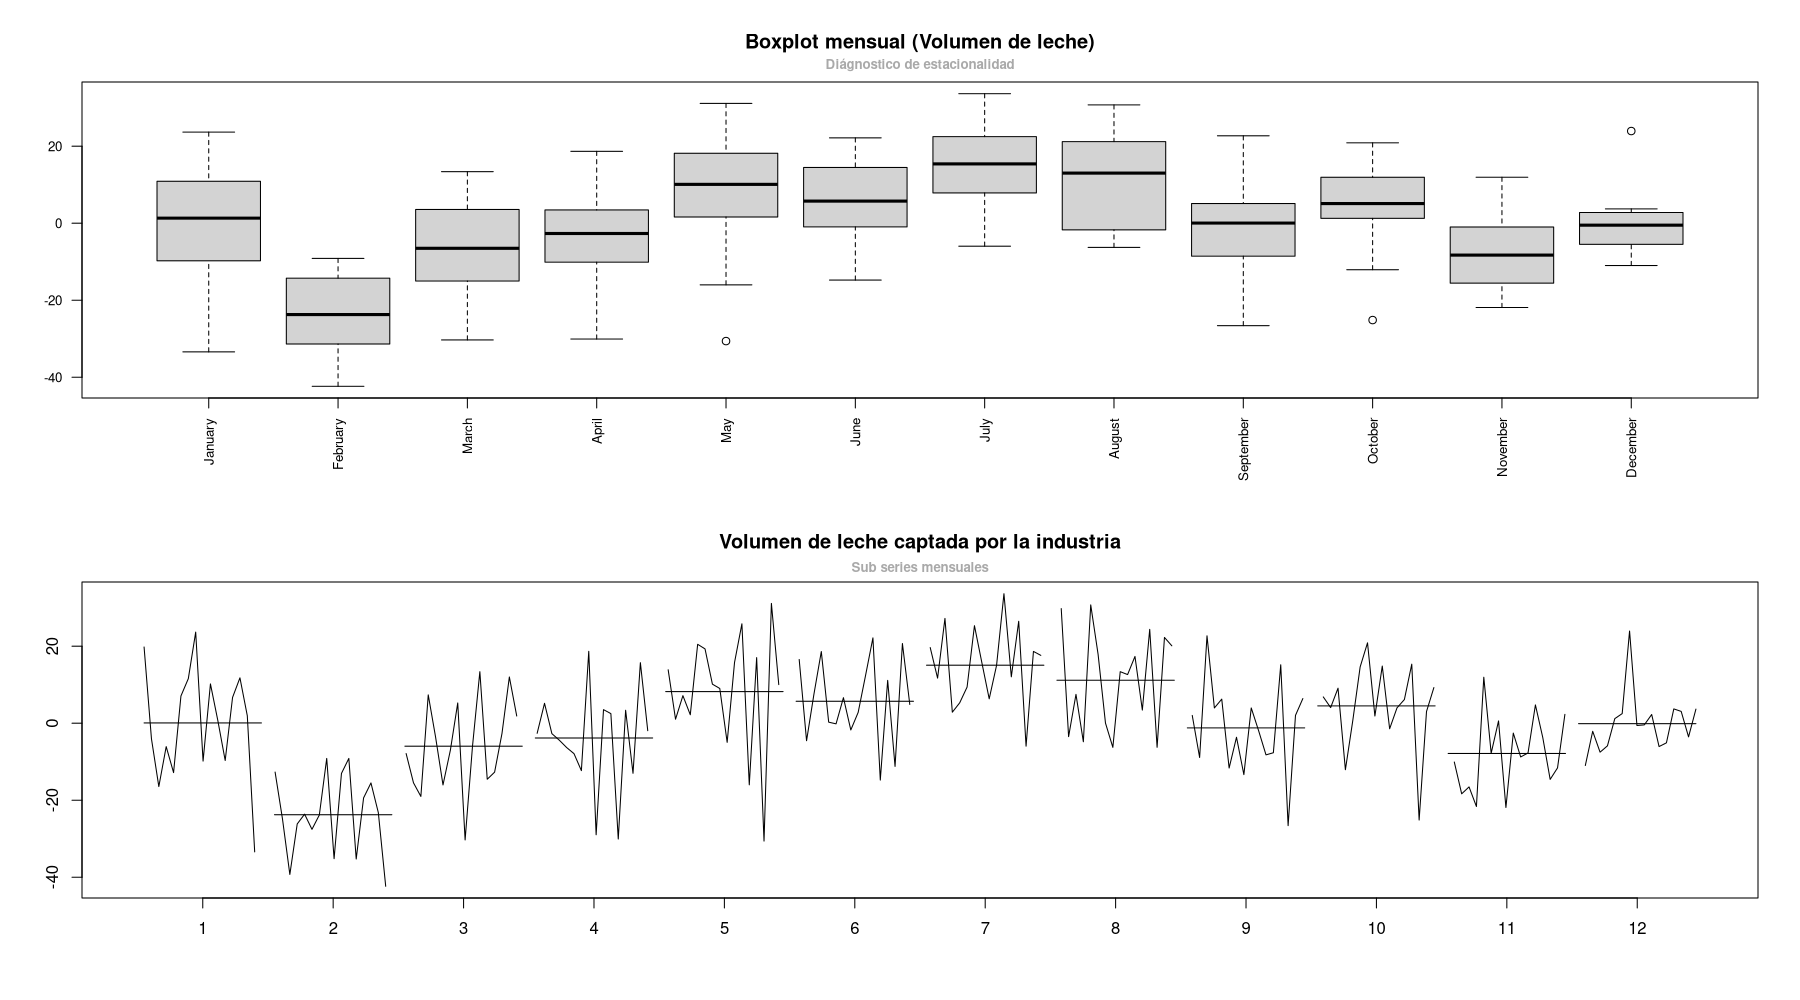

In [7]:
%%R -w 18 -h 10 --units in -r 100
colnames(leche) = c('Date', 'Volume')
months = 1:nrow(leche) %% 12
months[months == 0] = 12
leche$Month = month.name[months]

lechePorMeses = data.frame(row.names = month.name[1:12])
for (i in month.name[1:12]){
    lechePorMeses[i,1:16] = leche$Volume[leche$Month == i]
}

lechePorMeses = t(lechePorMeses)
rownames(lechePorMeses) = 2008:2023

par(mfrow = c(2,1))

# Gráfico de boxplot por meses
boxplot(lechePorMeses,las = 2, cex.axis = 0.8, main = 'Boxplot mensual (Volumen de leche)')
mtext(bquote(bold('Diágnostico de estacionalidad')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

# sub series mensuales
monthplot(leche$Volume, ylab = '', main = 'Volumen de leche captada por la industria')
mtext(bquote(bold('Sub series mensuales')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')


Nuevamente, es claro que existe algún tipo de estacionalidad ligada al mes en que se mide la serie debido a que se presentan distintas medias para cada sub serie mensual.

Finalmente, revisemos el periodograma para verificar que, además de la estacionalidad anual, no existan estacionalidades con otros períodos:

		 ---- LOS PRIMEROS TRES VALORES MÁXIMOS ----  

-	El valor máximo no. 1  en el que se máximiza el periodograma es 4488.692 en la frecuencia  0.08333333 
 	o lo que es equivalente a  1 años 
-	El valor máximo no. 2  en el que se máximiza el periodograma es 1798.497 en la frecuencia  0.04166667 
 	o lo que es equivalente a  0.5 años 
-	El valor máximo no. 3  en el que se máximiza el periodograma es 1420.426 en la frecuencia  0.4166667 
 	o lo que es equivalente a  5 años 






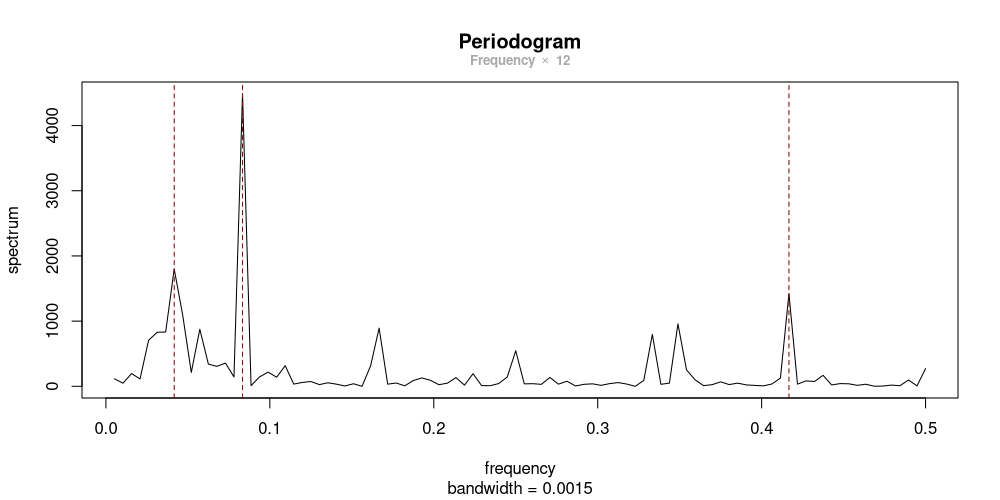

In [8]:
%%R -w 10 -h 5 --units in -r 100

library(latex2exp)
PeriodogramaLeche = spectrum(leche$Volume, log = 'no', main = 'Periodogram')
mtext(TeX('Frequency $\\times$ 12', bold = T),
      side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

Periodograma = PeriodogramaLeche$spec
frecuencias = PeriodogramaLeche$freq

cat('\t\t ---- LOS PRIMEROS TRES VALORES MÁXIMOS ---- ', end = '\n\n')
for (i in 1:3){
  ind = which.max(Periodograma)
  cat('-\tEl valor máximo no.', i, ' en el que se máximiza el periodograma es', Periodograma[ind], 'en la frecuencia ',
      frecuencias[ind],'\n \to lo que es equivalente a ',   frecuencias[ind] * 12 , 'años', end = '\n')
  abline(v = frecuencias[ind], col = 'darkred', lty = 2)
  Periodograma = Periodograma[-ind]
  frecuencias = frecuencias[-ind]
}

cat('\n\n\n\n')

Por lo que tal vez, sería pudente incluir los rezagos 6 y 12 en nuestro árbol de decisión. Por otro lado, a pesar de que no es importante realizar un reconocimiento funcional de las relaciones entre los rezagos para la construcción de un árbol de decisión de todas formas se muestra a continuación un gráfico de retardos:

#### Gráfico de retardos

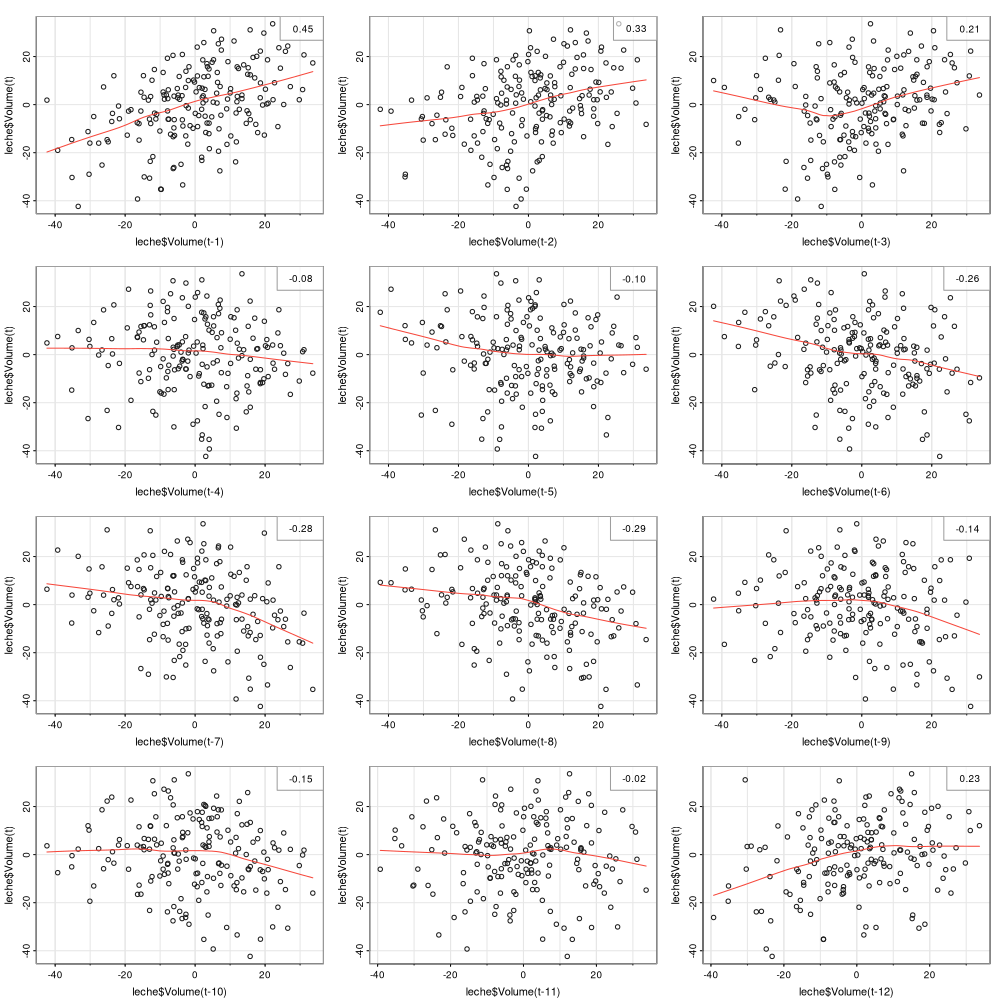

In [9]:
%%R -w 10 -h 10 --units in -r 100
# install.packages('astsa')
astsa::lag1.plot(leche$Volume, 12,corr = T)

En este caso también sería prudente incluir el primer rezago en la serie. Ahora bien, incluyamos 12 rezagos para mayor libertad a la hora de generar nuestro árbol de decisión.


### **Añadiendo los rezagos**

In [10]:
%%R -o arbolesLeche
arbolesLeche = data.frame(t = leche$Volume)               # Data frame con rezagos
rezagos = c(1,2,3,4,5,6,7,8,9,10,11,12)                   # Los rezagos que se quieran incluir se ponen aquí
NoDatos = nrow(leche)
for (i in rezagos){
    rezago = c(rep(NA, i), leche$Volume)[1:NoDatos]
    nombre = paste0('t - ', i)
    arbolesLeche = cbind(rezago, arbolesLeche)
    colnames(arbolesLeche)[1] = nombre
}

In [11]:
arbolesLeche

,t - 12,t - 11,t - 10,t - 9,t - 8,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1,t
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.795864
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.795864,-12.682066
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.795864,-12.682066,-7.872412
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.795864,-12.682066,-7.872412,-2.623688
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.795864,-12.682066,-7.872412,-2.623688,13.881874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,22.273918,2.036131,3.040229,-11.597113,-3.549744,-33.413477,-42.349878,1.871824,-1.942573,10.025542,4.868121,17.619143,20.100389
189,2.036131,3.040229,-11.597113,-3.549744,-33.413477,-42.349878,1.871824,-1.942573,10.025542,4.868121,17.619143,20.100389,6.408911
190,3.040229,-11.597113,-3.549744,-33.413477,-42.349878,1.871824,-1.942573,10.025542,4.868121,17.619143,20.100389,6.408911,9.259564
191,-11.597113,-3.549744,-33.413477,-42.349878,1.871824,-1.942573,10.025542,4.868121,17.619143,20.100389,6.408911,9.259564,2.303314


In [12]:
arbolesLeche = arbolesLeche[12:]
arbolesLeche

,t - 12,t - 11,t - 10,t - 9,t - 8,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1,t
13,19.795864,-12.682066,-7.872412,-2.623688,13.881874,16.555110,19.647754,29.772216,2.025085,6.830952,-10.072394,-10.988714,-4.030777
14,-12.682066,-7.872412,-2.623688,13.881874,16.555110,19.647754,29.772216,2.025085,6.830952,-10.072394,-10.988714,-4.030777,-24.838030
15,-7.872412,-2.623688,13.881874,16.555110,19.647754,29.772216,2.025085,6.830952,-10.072394,-10.988714,-4.030777,-24.838030,-15.479302
16,-2.623688,13.881874,16.555110,19.647754,29.772216,2.025085,6.830952,-10.072394,-10.988714,-4.030777,-24.838030,-15.479302,5.172316
17,13.881874,16.555110,19.647754,29.772216,2.025085,6.830952,-10.072394,-10.988714,-4.030777,-24.838030,-15.479302,5.172316,1.038858
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,22.273918,2.036131,3.040229,-11.597113,-3.549744,-33.413477,-42.349878,1.871824,-1.942573,10.025542,4.868121,17.619143,20.100389
189,2.036131,3.040229,-11.597113,-3.549744,-33.413477,-42.349878,1.871824,-1.942573,10.025542,4.868121,17.619143,20.100389,6.408911
190,3.040229,-11.597113,-3.549744,-33.413477,-42.349878,1.871824,-1.942573,10.025542,4.868121,17.619143,20.100389,6.408911,9.259564
191,-11.597113,-3.549744,-33.413477,-42.349878,1.871824,-1.942573,10.025542,4.868121,17.619143,20.100389,6.408911,9.259564,2.303314


### **Separando los datos entre datos de entrenamiento y prueba:**

Debido a